# Ejemplo de Diagrama de Voronoi

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/6-Planificacion-Movimiento/6-03-Diagramas-voronoi.ipynb)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, Voronoi

### Clase para realizar búsqueda usando el algoritmo de DIjkstra

In [4]:
class DijkstraSearch:
    class Node:
        """
        Node class for dijkstra search
        """
        def __init__(self, x, y, cost=None, parent=None, edge_ids=None):
            self.x = x
            self.y = y
            self.cost = cost
            self.parent = parent
            self.edge_ids = edge_ids

        def __str__(self):
            return str(self.x) + "," + str(self.y) + "," + str(
                self.cost) + "," + str(self.parent)

    def __init__(self, show_animation=False):
        self.show_animation = show_animation

    def search_voronoi(self, start, goal, voronoi):
        rx, ry = self.search(S[0], S[1], G[0], G[1], 
                             voronoi.sample_x, voronoi.sample_y,
                             voronoi.road_map_info)
        return rx, ry
        
    def search(self, sx, sy, gx, gy, node_x, node_y, edge_ids_list):
        """
        Search shortest path
        s_x: start x positions [m]
        s_y: start y positions [m]
        gx: goal x position [m]
        gx: goal x position [m]
        node_x: node x position
        node_y: node y position
        edge_ids_list: edge_list each item includes a list of edge ids
        """
        start_node = self.Node(sx, sy, 0.0, -1)
        goal_node = self.Node(gx, gy, 0.0, -1)
        current_node = None

        open_set, close_set = dict(), dict()
        open_set[self.find_id(node_x, node_y, start_node)] = start_node

        while True:
            if self.has_node_in_set(close_set, goal_node):
                print("goal is found!")
                goal_node.parent = current_node.parent
                goal_node.cost = current_node.cost
                break
            elif not open_set:
                print("Cannot find path")
                break

            current_id = min(open_set, key=lambda o: open_set[o].cost)
            current_node = open_set[current_id]

            # show graph
            if self.show_animation and len(
                    close_set.keys()) % 2 == 0:  # pragma: no cover
                plt.plot(current_node.x, current_node.y, "og")
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect(
                    'key_release_event',
                    lambda event: [exit(0) if event.key == 'escape' else None])
                plt.pause(0.1)

            # Remove the item from the open set
            del open_set[current_id]
            # Add it to the closed set
            close_set[current_id] = current_node

            # expand search grid based on motion model
            for i in range(len(edge_ids_list[current_id])):
                n_id = edge_ids_list[current_id][i]
                dx = node_x[n_id] - current_node.x
                dy = node_y[n_id] - current_node.y
                d = np.hypot(dx, dy)
                node = self.Node(node_x[n_id], node_y[n_id],
                                 current_node.cost + d, current_id)

                if n_id in close_set:
                    continue
                # Otherwise if it is already in the open set
                if n_id in open_set:
                    if open_set[n_id].cost > node.cost:
                        open_set[n_id] = node
                else:
                    open_set[n_id] = node

        # generate final course
        rx, ry = self.generate_final_path(close_set, goal_node)

        return rx, ry

    @staticmethod
    def generate_final_path(close_set, goal_node):
        rx, ry = [goal_node.x], [goal_node.y]
        parent = goal_node.parent
        while parent != -1:
            n = close_set[parent]
            rx.append(n.x)
            ry.append(n.y)
            parent = n.parent
        rx, ry = rx[::-1], ry[::-1]  # reverse it
        return rx, ry

    def has_node_in_set(self, target_set, node):
        for key in target_set:
            if self.is_same_node(target_set[key], node):
                return True
        return False

    def find_id(self, node_x_list, node_y_list, target_node):
        for i, _ in enumerate(node_x_list):
            if self.is_same_node_with_xy(node_x_list[i], node_y_list[i],
                                         target_node):
                return i
        return None

    @staticmethod
    def is_same_node_with_xy(node_x, node_y, node_b):
        dist = np.hypot(node_x - node_b.x,
                        node_y - node_b.y)
        return dist <= 0.1

    @staticmethod
    def is_same_node(node_a, node_b):
        dist = np.hypot(node_a.x - node_b.x,
                        node_b.y - node_b.y)
        return dist <= 0.1

### Clase para el diagrama de Voronoi

In [5]:
class VoronoiDiagram(object):

    def __init__(self, robot_radius, ox, oy):
        # Parameters
        self.N_KNN = 10                  # number of edge from one sampled point
        self.MAX_EDGE_LEN = 30.0         # [m] Maximum edge length
        self.robot_radius = robot_radius
        self.ox = ox
        self.oy = oy
    
    def generate(self, start, goal):
        self.sx = start[0]
        self.sy = start[1]
        self.gx = goal[0]
        self.gy = goal[1]
        obstacle_tree = cKDTree(np.vstack((self.ox, self.oy)).T)
        self.sample_x, self.sample_y = self.voronoi_sampling()
        self.road_map_info = self.generate_road_map_info(obstacle_tree)
            
    def is_collision(self, sx, sy, gx, gy, rr, obstacle_kd_tree):
        x = sx
        y = sy
        dx = gx - sx
        dy = gy - sy
        yaw = np.arctan2(gy-sy, gx-sx)
        d = np.hypot(dx, dy)
        if d >= self.MAX_EDGE_LEN:
            return True
        D = rr
        n_step = round(d / D)
        for i in range(n_step):
            dist, _ = obstacle_kd_tree.query([x, y])
            if dist <= rr:
                return True  # collision
            x += D * np.cos(yaw)
            y += D * np.sin(yaw)
        # Goal point check
        dist, _ = obstacle_kd_tree.query([gx, gy])
        if dist <= rr:
            return True  # collision
        return False  # OK
    
    def generate_road_map_info(self, obstacle_tree):
        """
        Road map generation
        node_x: [m] x positions of sampled points
        node_y: [m] y positions of sampled points
        rr: Robot Radius[m]
        obstacle_tree: KDTree object of obstacles
        """
        road_map = []
        n_sample = len(self.sample_x)
        node_tree = cKDTree(np.vstack((self.sample_x, self.sample_y)).T)
        for (i, ix, iy) in zip(range(n_sample), self.sample_x, self.sample_y):
            dists, indexes = node_tree.query([ix, iy], k=n_sample)
            edge_id = []
            for ii in range(1, len(indexes)):
                nx = self.sample_x[indexes[ii]]
                ny = self.sample_y[indexes[ii]]
                if not self.is_collision(ix, iy, nx, ny, self.robot_radius, obstacle_tree):
                    edge_id.append(indexes[ii])
                if len(edge_id) >= self.N_KNN:
                    break
            road_map.append(edge_id)
        return road_map

    def plot(self):
        plt.plot(self.sample_x, self.sample_y, ".y")
        
    def voronoi_sampling(self):
        oxy = np.vstack((self.ox, self.oy)).T
        # Generate voronoi point
        vor = Voronoi(oxy)
        sample_x = [ix for [ix, _] in vor.vertices]
        sample_y = [iy for [_, iy] in vor.vertices]
        sample_x.append(self.sx)
        sample_y.append(self.sy)
        sample_x.append(self.gx)
        sample_y.append(self.gy)
        return sample_x, sample_y

## Programa Principal

In [6]:
# Posición inicial y final
S = (10.0, 10.0)  # Start
G = (50.0, 50.0)  # Goal

# Tamaño del robot
robot_size = 5.0 

# Obstáculos (paredes)
ox = []
oy = []

for i in range(60):
    ox.append(i)
    oy.append(0.0)
for i in range(60):
    ox.append(60.0)
    oy.append(i)
for i in range(61):
    ox.append(i)
    oy.append(60.0)
for i in range(61):
    ox.append(0.0)
    oy.append(i)
for i in range(40):
    ox.append(20.0)
    oy.append(i)
for i in range(40):
    ox.append(40.0)
    oy.append(60.0-i)

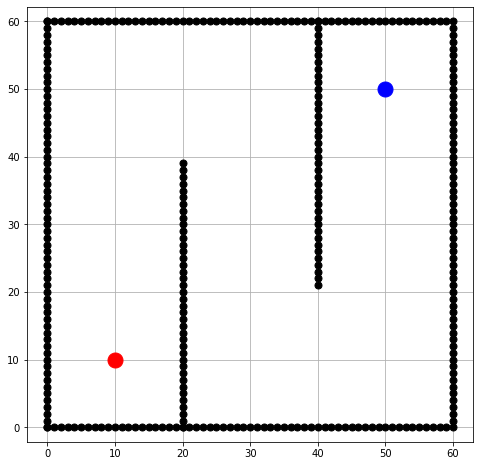

In [5]:
# Graficar punto de inicio (start) y punto objetivo (goal)
plt.figure(figsize=(8,8))
plt.plot(S[0], S[1], "or", markersize=15)
plt.plot(G[0], G[1], "ob", markersize=15)

# Mostrar el mapa inicial 
plt.plot(ox, oy, "ok", markersize=7)
plt.grid(True)
plt.axis("equal")

plt.show()

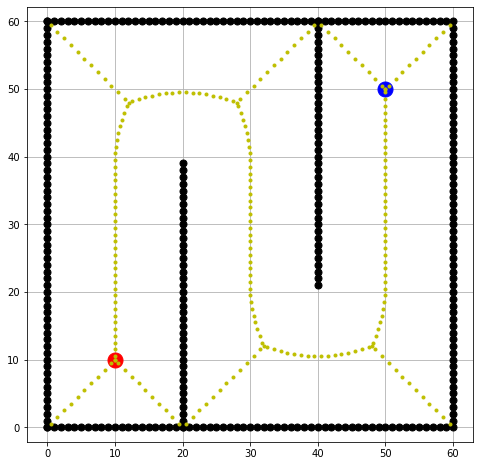

In [6]:
# Graficar punto de inicio (start) y punto objetivo (goal)
plt.figure(figsize=(8,8))
plt.plot(S[0], S[1], "or", markersize=15)
plt.plot(G[0], G[1], "ob", markersize=15)

# Mostrar el mapa inicial 
plt.plot(ox, oy, "ok", markersize=7)
plt.grid(True)
plt.axis("equal")

# Inicialización del modelo
voronoi = VoronoiDiagram(robot_size, ox, oy)
# Generar diagrama de Voronoi
voronoi.generate(S, G)
# Graficar el diagrama de Voronoi
voronoi.plot()

plt.show()

goal is found!


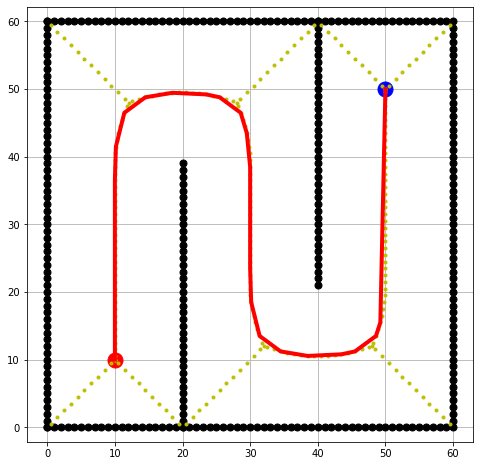

In [8]:
# Graficar punto de inicio (start) y punto objetivo (goal)
plt.figure(figsize=(8,8))
plt.plot(S[0], S[1], "or", markersize=15)
plt.plot(G[0], G[1], "ob", markersize=15)

# Mostrar el mapa inicial 
plt.plot(ox, oy, "ok", markersize=7)
plt.grid(True)
plt.axis("equal")

# Inicialización del modelo
voronoi = VoronoiDiagram(robot_size, ox, oy)
# Generar diagrama de Voronoi
voronoi.generate(S, G)
# Graficar el diagrama de Voronoi
voronoi.plot()

# Planificación del movimiento
planificador = DijkstraSearch()
traj_x, traj_y = planificador.search_voronoi(S, G, voronoi)

plt.plot(traj_x, traj_y, "-r", linewidth=4)
plt.pause(0.5)
plt.show()

In [7]:
%matplotlib qt

In [8]:
# Graficar punto de inicio (start) y punto objetivo (goal)
plt.figure(figsize=(8,8))
plt.plot(S[0], S[1], "or", markersize=15)
plt.plot(G[0], G[1], "ob", markersize=15)

# Mostrar el mapa inicial 
plt.plot(ox, oy, "ok", markersize=7)
plt.grid(True)
plt.axis("equal")

# Inicialización del modelo
voronoi = VoronoiDiagram(robot_size, ox, oy)
# Generar diagrama de Voronoi
voronoi.generate(S, G)
# Graficar el diagrama de Voronoi
voronoi.plot()

# Planificación del movimiento
planificador = DijkstraSearch(show_animation=True)
traj_x, traj_y = planificador.search_voronoi(S, G, voronoi)

plt.plot(traj_x, traj_y, "-r", linewidth=5)
plt.pause(0.5)
plt.show()

goal is found!
